In [2]:
import pandas as pd
dataset=pd.read_csv("G:/AIE/AIE SEM6/MIS-6/Project/CLUSTERING-OF-AIR-OBJECTS-BASED-ON-TRAJECTORY-and-missile-guidance-system-master/CLUSTERING-OF-AIR-OBJECTS-BASED-ON-TRAJECTORY-and-missile-guidance-system-master/data/abc2.csv")
dataset.head(105)

,Plane Number,Latitude,Longitude,Altitude,Velocity,Time
0,0,-13594,-9455,27,82,0
1,0,-13925,-9255,71,82,4
2,0,-14265,-9055,117,84,8
3,0,-14615,-8853,163,86,13
4,0,-14974,-8651,207,88,17
...,...,...,...,...,...,...
100,0,17221,21366,5676,217,462
101,0,18214,21583,5731,217,467
102,0,19211,21802,5785,217,472
103,0,20212,22026,5836,217,476


In [3]:
latitude=dataset.iloc[:50,1]
latitude=latitude.abs()
latitude

0     13594
1     13925
2     14265
3     14615
4     14974
5     15340
6     15716
7     16102
8     16494
9     16895
10    17305
11    17728
12    18165
13    18615
14    19077
15    19554
16    20043
17    20543
18    21048
19    21554
20    22059
21    22559
22    23062
23    23565
24    24077
25    24599
26    25134
27    25684
28    26241
29    26797
30    27346
31    27880
32    28381
33    28833
34    29220
35    29533
36    29762
37    29906
38    29967
39    29957
40    29899
41    29812
42    29703
43    29578
44    29440
45    29281
46    29084
47    28827
48    28493
49    28071
Name: Latitude , dtype: int64

In [4]:
len(latitude)

50

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,explained_variance_score,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error
from scipy.ndimage.filters import gaussian_filter
import matplotlib.dates as mdates

In [25]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    print("printing df.tail")
    print(df.tail())
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

In [26]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

# LSTM

In [32]:
def lstm_model(data_series, look_back, split, transforms, lstm_params):
    np.random.seed(1)
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)

    # training the model
    model = Sequential()
    model.add(SimpleRNN(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test = \
    inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #myFmt = mdates.DateFormatter('%m%/%y')
    #ax.xaxis.set_major_formatter(myFmt)
    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    # calculating RMSE metrics
    error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % error)
    error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % error)
    print("r2 score:" ,r2_score(test_predict,y_test))
    print("Explained Variance Score:", explained_variance_score(test_predict,y_test))
    print("Mean Absolute Error:", mean_absolute_error(test_predict,y_test))
    print("Mean absolute error:", median_absolute_error(test_predict,y_test))
    return train_predict, y_train, test_predict, y_test

printing df.tail
         t-0       t-1
45  0.239919  0.258569
46  0.206221  0.239919
47  0.152586  0.206221
48  0.082466  0.152586
49  0.000000  0.082466
Epoch 1/8
33/33 [==============================] - 1s 2ms/step - loss: 2.4155
Epoch 2/8
33/33 [==============================] - 0s 2ms/step - loss: 1.8869
Epoch 3/8
33/33 [==============================] - 0s 3ms/step - loss: 1.4754
Epoch 4/8
33/33 [==============================] - 0s 3ms/step - loss: 1.1577
Epoch 5/8
33/33 [==============================] - 0s 2ms/step - loss: 0.9070
Epoch 6/8
33/33 [==============================] - 0s 3ms/step - loss: 0.7071
Epoch 7/8
33/33 [==============================] - 0s 2ms/step - loss: 0.5434
Epoch 8/8
33/33 [==============================] - 0s 2ms/step - loss: 0.4096


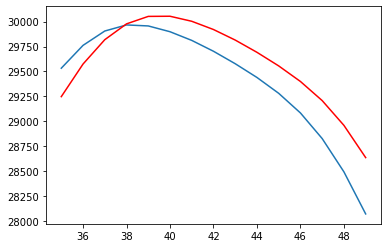

Train RMSE: 482.546
Test RMSE: 285.125
r2 score: 0.5277969092089421
Explained Variance Score: 0.7030225490298575
Mean Absolute Error: 248.31489109742083
Mean absolute error: 237.28688943957604


In [36]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 8
verbose = 1 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(latitude, look_back, split, transforms, lstm_params)


printing df.tail
         t-0       t-1
45  0.239919  0.258569
46  0.206221  0.239919
47  0.152586  0.206221
48  0.082466  0.152586
49  0.000000  0.082466
Epoch 1/7
33/33 [==============================] - 1s 2ms/step - loss: 0.2109
Epoch 2/7
33/33 [==============================] - 0s 2ms/step - loss: 0.0835
Epoch 3/7
33/33 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 4/7
33/33 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 5/7
33/33 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 6/7
33/33 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/7
33/33 [==============================] - 0s 2ms/step - loss: 0.0015


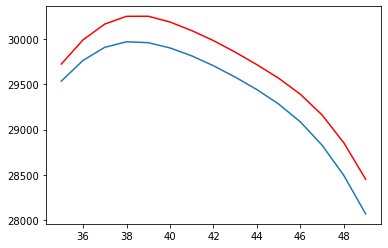

Train RMSE: 39.928
Test RMSE: 290.032
r2 score: 0.6897147082861652
Explained Variance Score: 0.9922413382881218
Mean Absolute Error: 286.3826107080698
Mean absolute error: 280.2883588993791


In [37]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 7
verbose = 1 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(latitude, look_back, split, transforms, lstm_params)
